# Project 2 - Anomaly Detection in caltech101
### Group 5: Yin Yin Thu, Wiwat Pholsomboon, Wassim Mecheri

## Introduction
- Detect non-airplane (anomaly) images in Caltech101 dataset
- Vanilla Autoencoder will be used to detect anomalies (non-airplane images)

## Data Preprocessing and Exploration

### Import libraries

In [1]:
# Import libraries
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc

BATCH_SIZE = 64
RANDOM_SEED = 555
IMAGE_SIZE = 96
LATENT_DIM = 512
THRESHOLD = 0.02
VERBOSE = 0

tf.random.set_seed(RANDOM_SEED)

### Load the Caltech101 dataset
- Images dataset which contain 102 classes.
- Visualize the distribution of classes in the dataset

2025-03-26 16:50:30.482715: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-26 16:50:30.482766: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-26 16:50:30.482772: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1743022230.482819 1733191 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743022230.482857 1733191 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-26 16:50:30.559516: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-26 16:50:31.204450: I tensorflow/core/framework/local_rendezvou

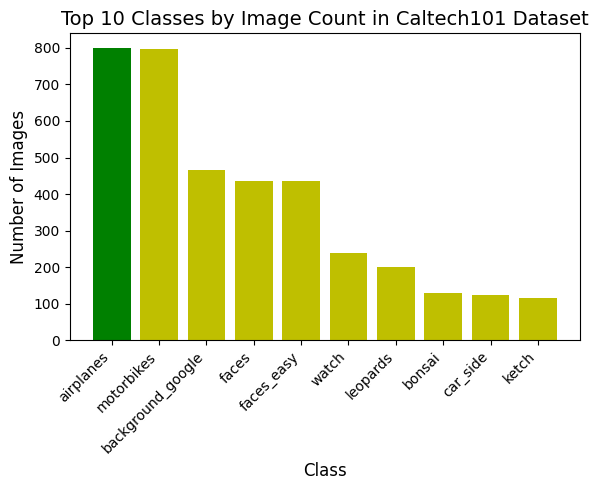

Total classes in dataset: 102
Total images in dataset: 9144


In [2]:
# Load and combine datasets
ds = tfds.load('caltech101', split='train+test', as_supervised=True)

# Count images per class
class_counts = {}
for _, label in ds:
    label_id = label.numpy()
    class_counts[label_id] = class_counts.get(label_id, 0) + 1

# Get class names
class_names = tfds.builder('caltech101').info.features['label'].names

# Create and sort DataFrame
df = pd.DataFrame({
    'class_name': [class_names[i] for i in class_counts.keys()],
    'count': list(class_counts.values())
})
top10_df = df.nlargest(10, 'count')

# Plot
plt.figure(figsize=(6, 5))
plt.bar(top10_df['class_name'], top10_df['count'], color=['g', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y'])
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Top 10 Classes by Image Count in Caltech101 Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary
print(f"Total classes in dataset: {len(class_names)}")
print(f"Total images in dataset: {sum(class_counts.values())}")

### Preprocessing
- Resize the image to 96x96
- Normalize the image pixel values to 0-1
- Split the dataset into normal, anomaly images and evaluation dataset

In [3]:
## Preprocessing
@tf.function
def scale_resize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE]) # Resizing the image to 224x224 dimention
    return (image, label)

combined_ds = (ds.map(scale_resize_image)).cache()
combined_images = [(image, label == 1) for image, label in combined_ds]

# Split 3 dataset
# For training and visualization
normal_images = np.array([image for image, airplane in combined_images if airplane == True ])
anomaly_images = np.array([image for image, airplane in combined_images if airplane == False ])

# For evaluation
test_X = np.array([image for (image, _) in combined_images])
test_y = np.array([0 if airplane == True else 1 for (_, airplane) in combined_images])

2025-03-26 16:50:32.026535: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Exploration

- Show sample images from normal (Airplane) and anomaly (Non-Airplane) classes

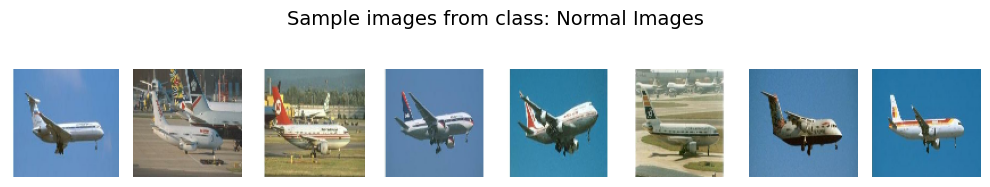

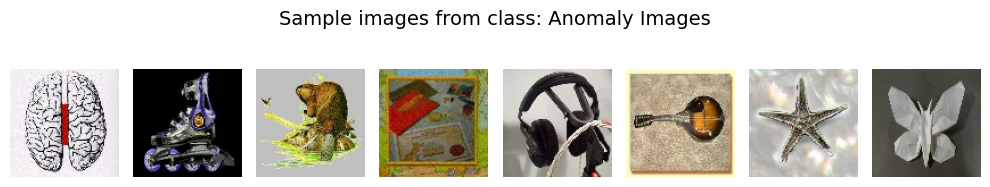

In [4]:
# Display sample images from specific classes
def show_class_samples(dataset, class_name, num_samples=8): 
     
    # Take the specified number of samples
    samples = dataset[:num_samples]
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
    fig.suptitle(f'Sample images from class: {class_name}', fontsize=14)
    
    # Display each sample
    for i, image in enumerate(samples):
        if i < num_samples:
            axes[i].imshow(image)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show samples from class 1 (airplane)
show_class_samples(normal_images, 'Normal Images')
show_class_samples(anomaly_images, 'Anomaly Images')


## Unsupervised Learning Model Development

### Vanilla Autoencoder
- Encoder contains 3 convolutional layers and 1 fully connected layer
- Decoder contains 4 convolutional transpose layers

In [5]:
# Build the Autoencoder model
class Autoencoder(keras.Model):
    def __init__(self, img_shape, latent_dim, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.encoder = tf.keras.Sequential(
            [
                
                layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(128, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Flatten(),
                layers.Dense(256, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Dense(latent_dim, name="latent_vector", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
            ]
        )
        
        h, w, c = img_shape
        encoder_conv_layers = 3
        decoder_starting_dims = (h // (2 ** encoder_conv_layers), w // (2 ** encoder_conv_layers), 128)
        
        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(np.prod(decoder_starting_dims), activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Reshape(decoder_starting_dims),
                layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(3, 3, activation="sigmoid", padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
            ]
        )
        
    def call(self, inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

# Main training function
def train_autoencoder(dataset, img_shape=(224, 224, 3), latent_dim=64, epochs=20, learning_rate=0.001):
    # Create Autoencoder
    autoencoder = Autoencoder(img_shape, latent_dim)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse", metrics=["mse"])
    
    # Train the model
    history = autoencoder.fit(dataset, dataset, epochs=epochs, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    return autoencoder, history

# Generate reconstructions from the autoencoder
def generate_reconstructions(autoencoder, test_images, n=8):
    # Get test images
    test_sample = test_images[:n]
    # Get reconstructions
    reconstructed = autoencoder.predict(test_sample, verbose=VERBOSE)
    
    return test_sample, reconstructed

# Visualize original vs reconstructed images
def visualize_reconstructions(originals, reconstructions, n=8):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(14, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis("off")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

### Train the Autoencoder and generate reconstructions
- Train the autoencoder with normal images (Airplane)
- Generate reconstructions from the autoencoder
- Loss function is Mean Squared Error (MSE)
- Optimizer is Adam with learning rate 0.001

2025-03-26 16:50:33.964570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


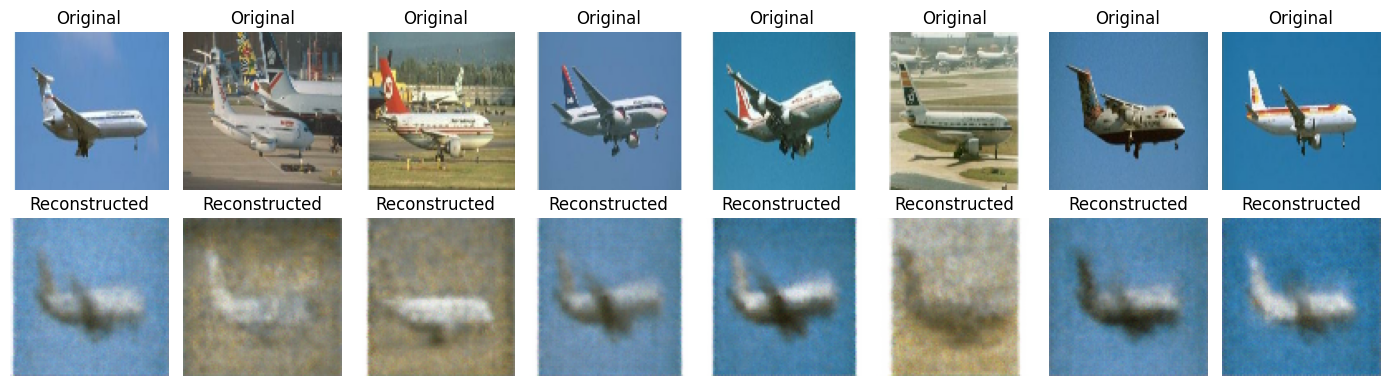

In [6]:
# Train the autoencoder
autoencoder, history = train_autoencoder(normal_images, img_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), latent_dim=LATENT_DIM, epochs=20)

# Generate reconstructions
original, reconstructed = generate_reconstructions(autoencoder, normal_images, n=8)
visualize_reconstructions(original, reconstructed, n=8)

## Anomaly Detection

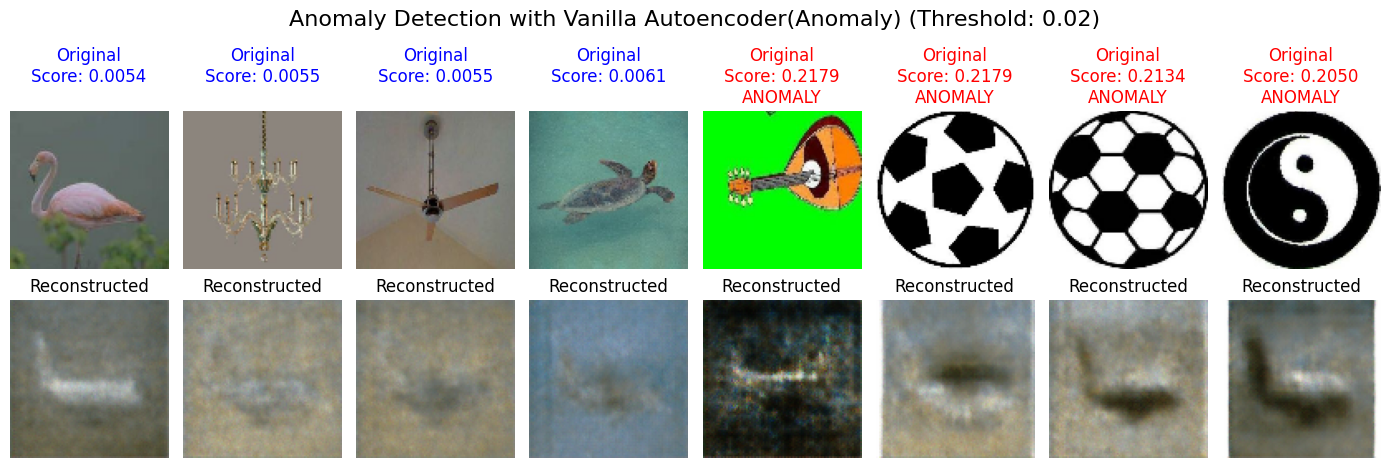

Vanilla Autoencoder detected 7822 anomalies from 8344 images


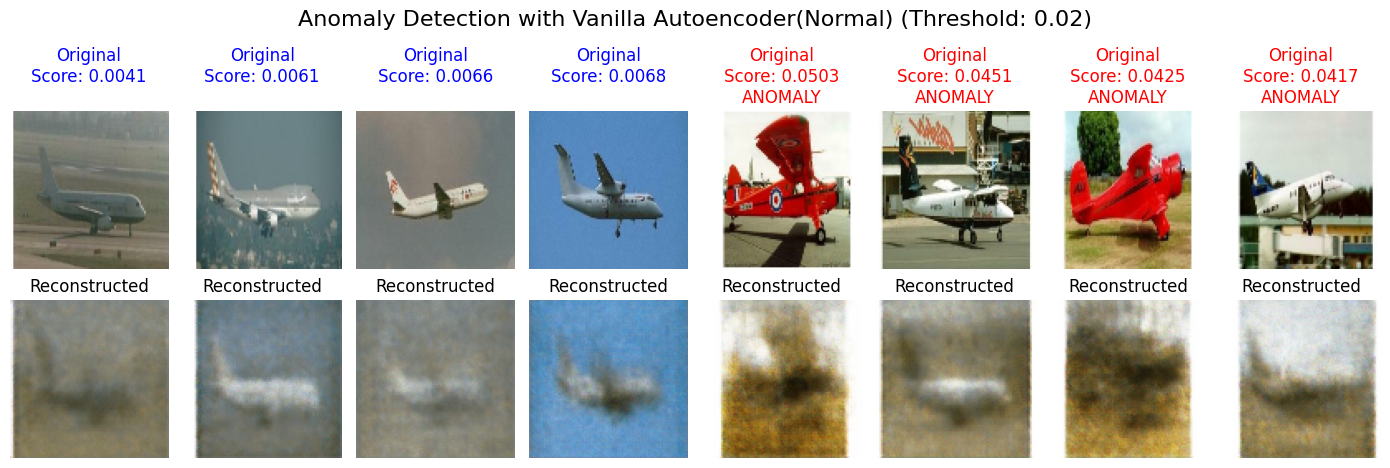

Vanilla Autoencoder disclassified 193 normal images from 800 images


In [7]:
# Function to detect anomalies using autoencoder
def detect_anomalies_autoencoder(autoencoder, images, threshold): 
    reconstructions = autoencoder.predict(images, verbose=VERBOSE) 
    # Calculate MSE for each image
    mse = np.mean(np.square(images - reconstructions), axis=(1, 2, 3)) 
    # Determine if each image is an anomaly based on threshold
    anomalies = mse > threshold 
    return mse, anomalies, reconstructions

# Function to visualize anomalies
def visualize_anomalies(original_images, reconstructions, scores, anomalies, model_name, n=8): 
        
    plt.figure(figsize=(14, 5))
    # Sort indices by scores in ascending and descending order
    asc_indices = np.argsort(scores)[:4]  # First 4 with lowest scores (ascending)
    desc_indices = np.argsort(scores)[::-1][:4]  # Last 4 with highest scores (descending)
    
    # Combine indices: first 4 ascending, last 4 descending
    display_indices = np.concatenate([asc_indices, desc_indices])
    
    for i in range(min(n, len(original_images))):
        idx = display_indices[i]
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[idx])
        title = f"Original\nScore: {scores[idx]:.4f}"
        if anomalies[idx]:
            title += "\nANOMALY"
        else:
            title += "\n"
        plt.title(title, color=('red' if anomalies[idx] else 'blue'))
        plt.axis("off")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[idx])
        plt.title("Reconstructed")
        plt.axis("off")
        
    plt.suptitle(f"Anomaly Detection with {model_name} (Threshold: {threshold})", fontsize=16)
    plt.tight_layout()
    plt.show() 
    
threshold = 0.02
# Detect anomalies with regular autoencoder
ae_scores, ae_anomalies, ae_reconstructions = detect_anomalies_autoencoder(autoencoder, anomaly_images, threshold=threshold)
visualize_anomalies(anomaly_images, ae_reconstructions, ae_scores, ae_anomalies, "Vanilla Autoencoder(Anomaly)")

print(f"Vanilla Autoencoder detected {np.sum(ae_anomalies)} anomalies from {len(anomaly_images)} images")

# Detect anomalies with regular autoencoder
normal_scores, normal_anomalies, normal_reconstructions = detect_anomalies_autoencoder(autoencoder, normal_images, threshold=threshold)
visualize_anomalies(normal_images, normal_reconstructions, normal_scores, normal_anomalies, "Vanilla Autoencoder(Normal)")

print(f"Vanilla Autoencoder disclassified {np.sum(normal_anomalies)} normal images from {len(normal_images)} images")
 

## Actionable Recommendations

### Feature Analysis
#### Anomaly Item detected as Normal(Airplane)
- Has background color as grey or blue.
- Has object on the center of the image.
- Majority of the image is background.

#### Normal Item detected as Anomaly(Non-Airplane)
- Plane is in red color and cover more than 50% of the image.
- Plane which station on the ground and the background is not sky.


### Actionable Recommendations
- Increase complexity of the model to detect more patterns.
- Increase size of dataset use to train the model. Especially on red airplane and airplane station on the ground.
- Increase latent dimension to capture more features.



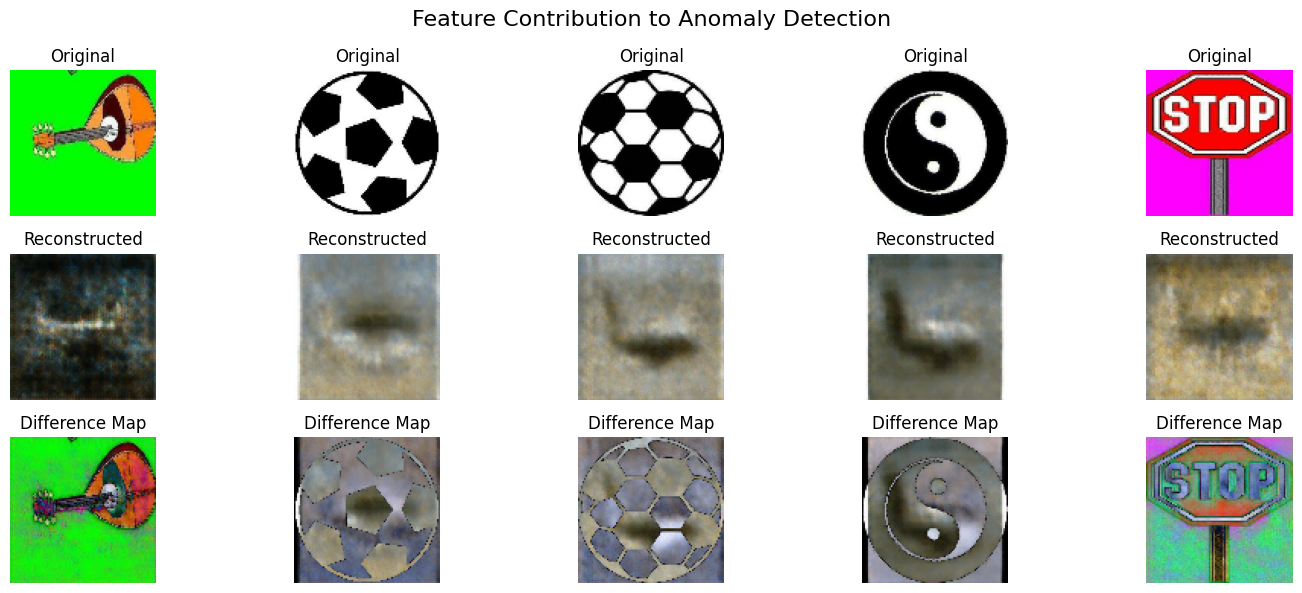

In [8]:
# Actionable Recommendations (4 marks)

## Feature Importance Analysis
# Function to visualize the difference between original and reconstructed images
def visualize_difference_maps(originals, reconstructions, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(min(n, len(originals))):
        # Original
        plt.subplot(3, n, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis("off")
        
        # Reconstruction
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
        # Difference map
        diff = np.abs(originals[i] - reconstructions[i])
        # Normalize for better visualization
        diff = diff / np.max(diff) if np.max(diff) > 0 else diff
        
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(diff, cmap='hot')
        plt.title("Difference Map")
        plt.axis("off")
        
    plt.suptitle("Feature Contribution to Anomaly Detection", fontsize=16)
    plt.tight_layout()
    plt.show()

# Select some high-anomaly score examples
anomaly_indices = np.argsort(-ae_scores)[:5]  # Top 5 highest anomaly scores
high_anomaly_imgs = anomaly_images[anomaly_indices]
high_anomaly_recon = ae_reconstructions[anomaly_indices] 
visualize_difference_maps(high_anomaly_imgs, high_anomaly_recon)

<div class='alert alert-block alert-info'>
      Bright color in Difference Map indicated area that is different between original and reconstructed images. 
</div>

## Evaluation and Visualization

- Calculate evaluation metrics for vanilla autoencoder.
- Plot ROC/AUC curve vanilla autoencoder.

Calculating performance metrics for Vanilla Autoencoder...

Autoencoder Performance Metrics:
+-----------------+-----------+
| Metric          |     Value |
+=================+===========+
| Accuracy        |    0.9218 |
+-----------------+-----------+
| Precision       |    0.9759 |
+-----------------+-----------+
| Recall          |    0.9374 |
+-----------------+-----------+
| F1 Score        |    0.9563 |
+-----------------+-----------+
| True Positives  | 7822      |
+-----------------+-----------+
| False Positives |  193      |
+-----------------+-----------+
| True Negatives  |  607      |
+-----------------+-----------+
| False Negatives |  522      |
+-----------------+-----------+


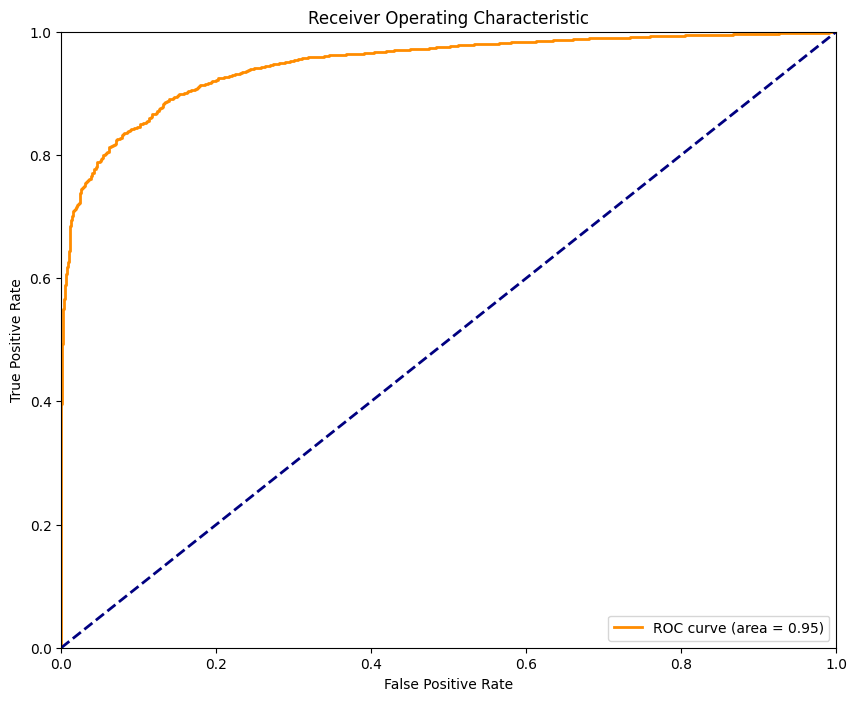

In [9]:
def calculate_metrics(y_true, scores, threshold):
    # Convert scores to predictions based on threshold
    y_pred = (scores > threshold).astype(int)
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
     
    return [
        ["Metric", "Value"],
        ["Accuracy", f"{accuracy:.4f}"],
        ["Precision", f"{precision:.4f}"],
        ["Recall", f"{recall:.4f}"],
        ["F1 Score", f"{f1:.4f}"],
        ["True Positives", tp],
        ["False Positives", fp],
        ["True Negatives", tn],
        ["False Negatives", fn]
    ]

# Calculate metrics for both models on the test set
print("Calculating performance metrics for Vanilla Autoencoder...")
ae_reconstructed = autoencoder.predict(test_X, verbose=VERBOSE)
ae_mse = np.mean(np.square(test_X - ae_reconstructed), axis=(1,2,3))
ae_metrics = calculate_metrics(test_y, ae_mse, THRESHOLD) 

print("\nAutoencoder Performance Metrics:")
print(tabulate(ae_metrics, headers="firstrow", tablefmt="grid"))

# Calculate ROC AUC score
fpr_vanilla, tpr_vanilla, thresholds  = roc_curve(test_y, ae_mse)

# Calculate Area Under Curve (AUC)
roc_auc_vanilla = auc(fpr_vanilla, tpr_vanilla)

# Plot ROC curve
plt.figure(figsize=(10, 8)) 
plt.plot(fpr_vanilla, tpr_vanilla, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_vanilla:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model Refinement and Optimization
1. Try to use VAE to improve the performance of the model.
2. Hyperparameter tuning on Vanilla Autoencoder in various threshold.

### 1. Variational Autoencoder
- define function to train, visualize, and detect anomalies for VAE

In [10]:
# Build the VAE model
class VAE(keras.Model):
    def __init__(self, img_shape, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = keras.Sequential(
            [
                layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(128, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Flatten(),
                layers.Dense(256, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Dense(latent_dim * 2, name="latent_vector", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
            ]
        )
        
        h, w, c = img_shape
        encoder_conv_layers = 3
        decoder_starting_dims = (h // (2 ** encoder_conv_layers), w // (2 ** encoder_conv_layers), 128)
        
        self.decoder = keras.Sequential(
            [
                layers.Dense(np.prod(decoder_starting_dims), activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Reshape(decoder_starting_dims),
                layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(c, 3, activation="sigmoid", padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
            ]
        )
        
    def encode(self, x):
        mean_log_var = self.encoder(x)
        mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + eps * tf.exp(log_var * 0.5)
    
    def decode(self, z):
        return self.decoder(z)
    
    def call(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        
        # Add KL divergence loss as a model metric
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
        )
        self.add_loss(kl_loss)
        
        return reconstructed
        
# Main training function
def train_vae(dataset, img_shape=(224, 224, 3), latent_dim=64, epochs=20, learning_rate=0.001): 
    # Create VAE
    vae = VAE(img_shape, latent_dim)
     
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse", metrics=["mse"])
    
    # Train the model
    history = vae.fit(dataset, dataset, batch_size=BATCH_SIZE, epochs=epochs, verbose=VERBOSE)
    
    return vae, history

# Generate reconstructions from the VAE
def generate_vae_reconstructions(vae, test_images, n=8):
    # Get test images
    test_sample = test_images[:n]
    
    # For VAE, we need to get the latent representation first
    z_mean, z_log_var = vae.encode(test_sample)
    z = vae.reparameterize(z_mean, z_log_var)
    
    # Generate reconstructions using the decoder
    reconstructed = vae.decoder(z)
    
    return test_sample, reconstructed

def visualize_vae_reconstructions(originals, reconstructions, n=8):
    plt.figure(figsize=(14, 4))
    for i in range(min(n, len(originals))):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis("off")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()


#### Train the VAE model

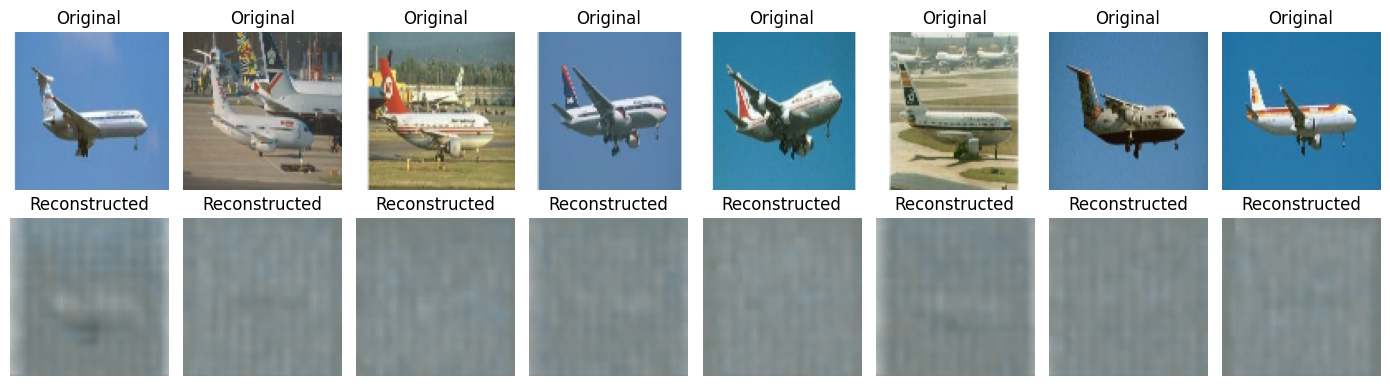

In [11]:
vae, history = train_vae(normal_images, img_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), latent_dim=LATENT_DIM, epochs=20)

original, reconstructed = generate_vae_reconstructions(vae, normal_images, n=8)
visualize_vae_reconstructions(original, reconstructed, n=8)

### Visualize result of VAE

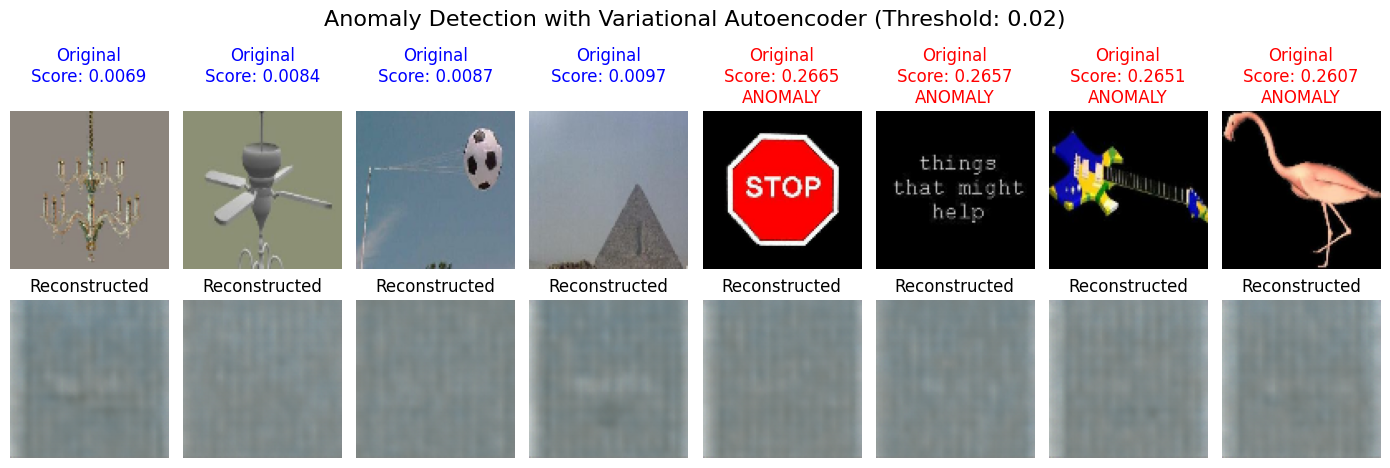

Vanilla Autoencoder detected 7822 anomalies from 8344 images
VAE detected 8295 anomalies from 8344 images


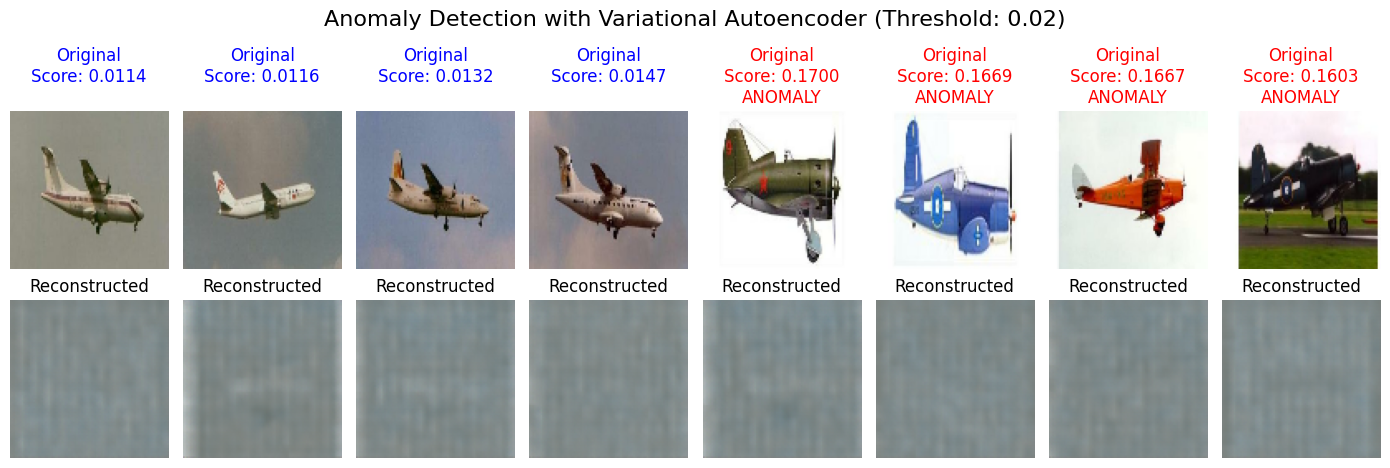

In [12]:
def detect_anomalies_vae(vae, images, threshold): 
    # Get latent representation
    z_mean, z_log_var = vae.encode(images)
    z = vae.reparameterize(z_mean, z_log_var)
    # Generate reconstructions
    reconstructions = vae.decoder(z)
    
    # Calculate MSE for each image
    mse = np.mean(np.square(images - reconstructions), axis=(1, 2, 3))
    
    # Determine if each image is an anomaly based on threshold
    anomalies = mse > threshold
    
    return mse, anomalies, reconstructions

# Detect anomalies with VAE
vae_scores, vae_anomalies, vae_reconstructions = detect_anomalies_vae(vae, anomaly_images, threshold=THRESHOLD)
visualize_anomalies(anomaly_images, vae_reconstructions, vae_scores, vae_anomalies, "Variational Autoencoder")

# Compare the anomaly detection results
print(f"Vanilla Autoencoder detected {np.sum(ae_anomalies)} anomalies from {len(anomaly_images)} images")
print(f"VAE detected {np.sum(vae_anomalies)} anomalies from {len(anomaly_images)} images")

normal_scores, normal_anomalies, normal_reconstructions = detect_anomalies_vae(vae, normal_images, threshold=THRESHOLD)
visualize_anomalies(normal_images, normal_reconstructions, normal_scores, normal_anomalies, "Variational Autoencoder")




### Plot performance metrics of VAE
- Bases on the performance metrics, VAE perform worse than Vanilla Autoencoder in this dataset.


VAE Performance Metrics:
+-----------------+-----------+
| Metric          |     Value |
+=================+===========+
| Accuracy        |    0.9128 |
+-----------------+-----------+
| Precision       |    0.913  |
+-----------------+-----------+
| Recall          |    0.9998 |
+-----------------+-----------+
| F1 Score        |    0.9544 |
+-----------------+-----------+
| True Positives  | 8342      |
+-----------------+-----------+
| False Positives |  795      |
+-----------------+-----------+
| True Negatives  |    5      |
+-----------------+-----------+
| False Negatives |    2      |
+-----------------+-----------+


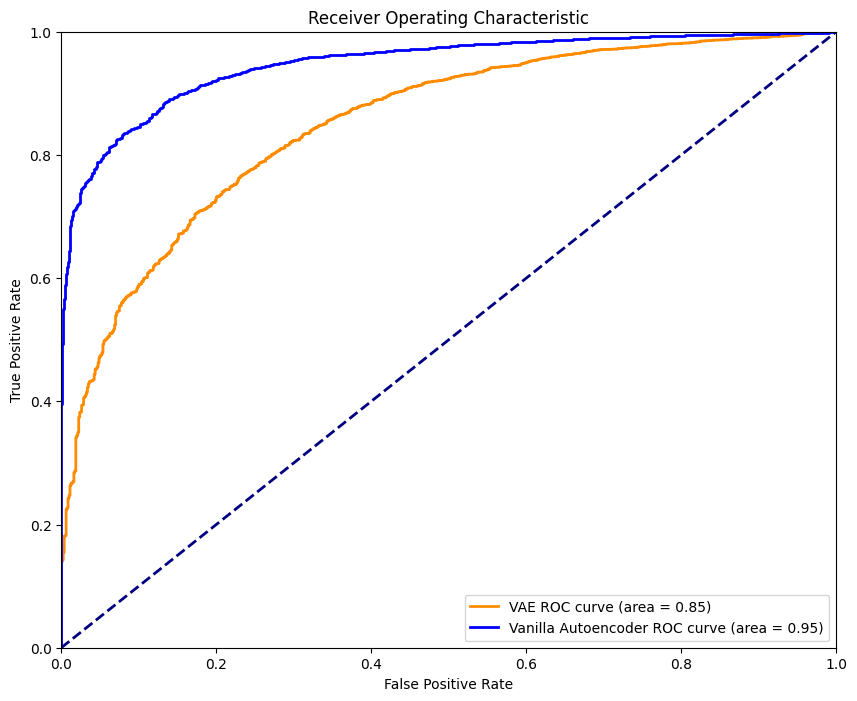

In [13]:
reconstructed = vae.predict(test_X, verbose=VERBOSE)
vae_mse = np.mean(np.square(test_X - reconstructed), axis=(1,2,3))
vae_metrics = calculate_metrics(test_y, vae_mse, THRESHOLD)
# Display metrics in a table format
print("\nVAE Performance Metrics:")
print(tabulate(vae_metrics, headers="firstrow", tablefmt="grid"))

# Calculate ROC AUC score
fpr_vae, tpr_vae, thresholds  = roc_curve(test_y, vae_mse)

# Calculate Area Under Curve (AUC)
roc_auc_vae = auc(fpr_vae, tpr_vae)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_vae, tpr_vae, color='darkorange', lw=2, label=f'VAE ROC curve (area = {roc_auc_vae:.2f})')
plt.plot(fpr_vanilla, tpr_vanilla, color='blue', lw=2, label=f'Vanilla Autoencoder ROC curve (area = {roc_auc_vanilla:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### 2. Hyperparameter Tuning on Vanilla Autoencoder in various threshold

In [14]:
thresholds = [0.01, 0.02, 0.03, 0.04, 0.05]

# Store metrics for each threshold
all_metrics = {}

for threshold in thresholds:
    # Get metrics for current threshold
    metrics = calculate_metrics(test_y, ae_mse, threshold)
    
    # Extract metric names and values (skip header row)
    metric_data = metrics[1:]
    
    # Initialize dictionary on first run
    if not all_metrics:
        all_metrics = {row[0]: [] for row in metric_data}
    
    # Add values for this threshold
    for row in metric_data:
        all_metrics[row[0]].append(row[1])

# Build the table
header_row = ["Metric"] + [f"{t}" for t in thresholds]
combined_table = [header_row]

# Add each metric row
for metric, values in all_metrics.items():
    combined_table.append([metric] + values)

# Display results
print("Vanilla Autoencoder Performance Across Thresholds:")
print(tabulate(combined_table, headers="firstrow", tablefmt="grid"))

Vanilla Autoencoder Performance Across Thresholds:
+-----------------+-----------+-----------+-----------+-----------+-----------+
| Metric          |      0.01 |      0.02 |      0.03 |      0.04 |      0.05 |
+=================+===========+===========+===========+===========+===========+
| Accuracy        |    0.9206 |    0.9218 |    0.8077 |    0.6389 |    0.4521 |
+-----------------+-----------+-----------+-----------+-----------+-----------+
| Precision       |    0.924  |    0.9759 |    0.9937 |    0.999  |    0.9997 |
+-----------------+-----------+-----------+-----------+-----------+-----------+
| Recall          |    0.9948 |    0.9374 |    0.7943 |    0.6049 |    0.3997 |
+-----------------+-----------+-----------+-----------+-----------+-----------+
| F1 Score        |    0.9581 |    0.9563 |    0.8829 |    0.7535 |    0.5711 |
+-----------------+-----------+-----------+-----------+-----------+-----------+
| True Positives  | 8301      | 7822      | 6628      | 5047      | 3

<div class='alert alert-block alert-info'>
- Threshold 0.01 has the highest f1 score and accuracy indicating best performance. </br>
- By the way, in real life scenario, we might need to consider the cost of false alarm and false negative on Airplane detection which might make 0.05 the best threshold if Airplant miss detection is costly.
</div>

### 1. β-VAE
As we can see, VAE is unsusccesful at reconstructing the pictures. The output are grey images and it's impossible to recognize the planes, anomalies or not.  
A reason for that might be that the KL divergence overpowering the reconstruction loss and making the images like that, to deal with this we can add a β (beta) term to the KL divergence to reduce it's impact on the function.

In [16]:
# Build the VAE model
class VAE(keras.Model):
    def __init__(self, img_shape, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = keras.Sequential(
            [
                layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(128, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Flatten(),
                layers.Dense(256, activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Dense(latent_dim * 2, name="latent_vector", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
            ]
        )
        
        h, w, c = img_shape
        encoder_conv_layers = 3
        decoder_starting_dims = (h // (2 ** encoder_conv_layers), w // (2 ** encoder_conv_layers), 128)
        
        self.decoder = keras.Sequential(
            [
                layers.Dense(np.prod(decoder_starting_dims), activation="relu", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Reshape(decoder_starting_dims),
                layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
                layers.Conv2D(c, 3, activation="sigmoid", padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)),
            ]
        )
        
    def encode(self, x):
        mean_log_var = self.encoder(x)
        mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + eps * tf.exp(log_var * 0.5)
    
    def decode(self, z):
        return self.decoder(z)
    
    def call(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        
        # Add KL divergence loss as a model metric
        beta = 0.0001  # add beta
        kl_loss = beta * (-0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
            ))
        self.add_loss(kl_loss)

        
        return reconstructed
        
# Main training function
def train_vae(dataset, img_shape=(224, 224, 3), latent_dim=64, epochs=20, learning_rate=0.001): 
    # Create VAE
    vae = VAE(img_shape, latent_dim)
     
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse", metrics=["mse"])
    
    # Train the model
    history = vae.fit(dataset, dataset, batch_size=BATCH_SIZE, epochs=epochs, verbose=VERBOSE)
    
    return vae, history

# Generate reconstructions from the VAE
def generate_vae_reconstructions(vae, test_images, n=8):
    # Get test images
    test_sample = test_images[:n]
    
    # For VAE, we need to get the latent representation first
    z_mean, z_log_var = vae.encode(test_sample)
    z = vae.reparameterize(z_mean, z_log_var)
    
    # Generate reconstructions using the decoder
    reconstructed = vae.decoder(z)
    
    return test_sample, reconstructed

def visualize_vae_reconstructions(originals, reconstructions, n=8):
    plt.figure(figsize=(14, 4))
    for i in range(min(n, len(originals))):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis("off")
        
        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()


#### Train the β-VAE model

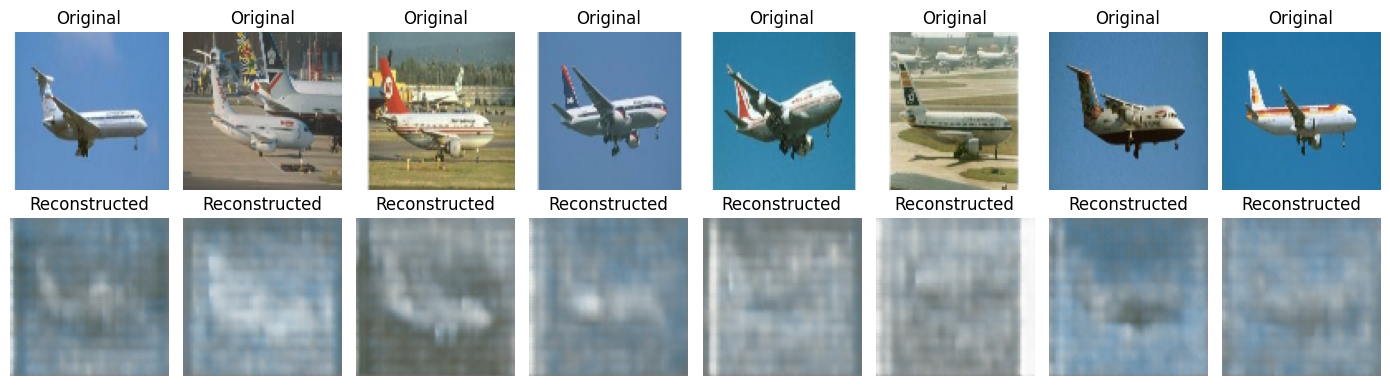

In [17]:
vae, history = train_vae(normal_images, img_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), latent_dim=LATENT_DIM, epochs=20)

original, reconstructed = generate_vae_reconstructions(vae, normal_images, n=8)
visualize_vae_reconstructions(original, reconstructed, n=8)

### Visualize result of β-VAE

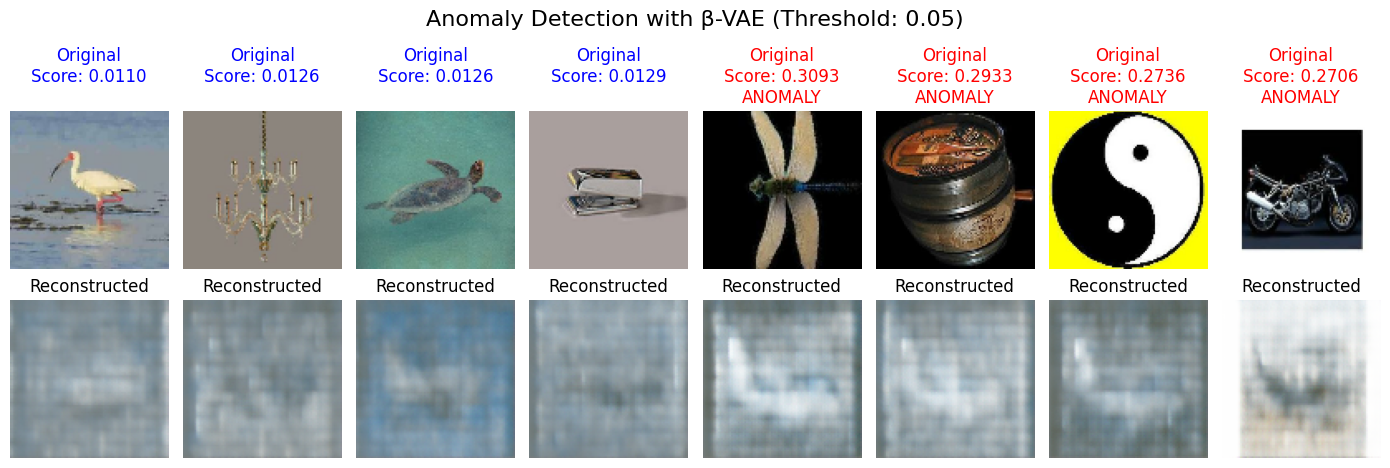

Vanilla Autoencoder detected 7822 anomalies from 8344 images
VAE detected 8321 anomalies from 8344 images


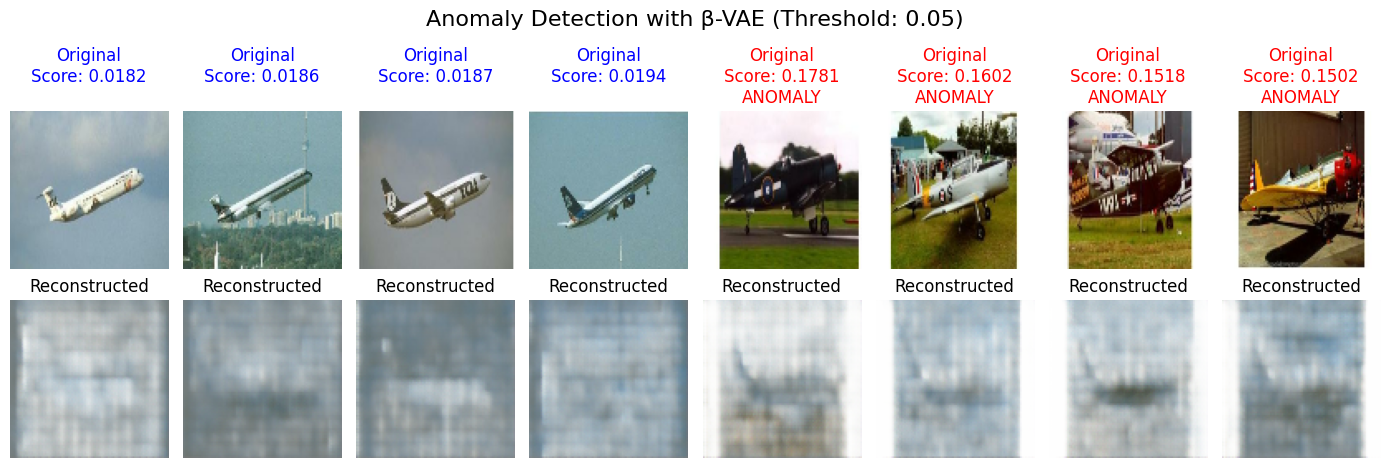

In [18]:
def detect_anomalies_vae(vae, images, threshold): 
    # Get latent representation
    z_mean, z_log_var = vae.encode(images)
    z = vae.reparameterize(z_mean, z_log_var)
    # Generate reconstructions
    reconstructions = vae.decoder(z)
    
    # Calculate MSE for each image
    mse = np.mean(np.square(images - reconstructions), axis=(1, 2, 3))
    
    # Determine if each image is an anomaly based on threshold
    anomalies = mse > threshold
    
    return mse, anomalies, reconstructions

# Detect anomalies with VAE
vae_scores, vae_anomalies, vae_reconstructions = detect_anomalies_vae(vae, anomaly_images, threshold=THRESHOLD)
visualize_anomalies(anomaly_images, vae_reconstructions, vae_scores, vae_anomalies, "β-VAE")

# Compare the anomaly detection results
print(f"Vanilla Autoencoder detected {np.sum(ae_anomalies)} anomalies from {len(anomaly_images)} images")
print(f"VAE detected {np.sum(vae_anomalies)} anomalies from {len(anomaly_images)} images")

normal_scores, normal_anomalies, normal_reconstructions = detect_anomalies_vae(vae, normal_images, threshold=THRESHOLD)
visualize_anomalies(normal_images, normal_reconstructions, normal_scores, normal_anomalies, "β-VAE")




### Plot performance metrics of β-VAE


β-VAE Performance Metrics:
+-----------------+-----------+
| Metric          |     Value |
+=================+===========+
| Accuracy        |    0.9263 |
+-----------------+-----------+
| Precision       |    0.944  |
+-----------------+-----------+
| Recall          |    0.9772 |
+-----------------+-----------+
| F1 Score        |    0.9603 |
+-----------------+-----------+
| True Positives  | 8154      |
+-----------------+-----------+
| False Positives |  484      |
+-----------------+-----------+
| True Negatives  |  316      |
+-----------------+-----------+
| False Negatives |  190      |
+-----------------+-----------+


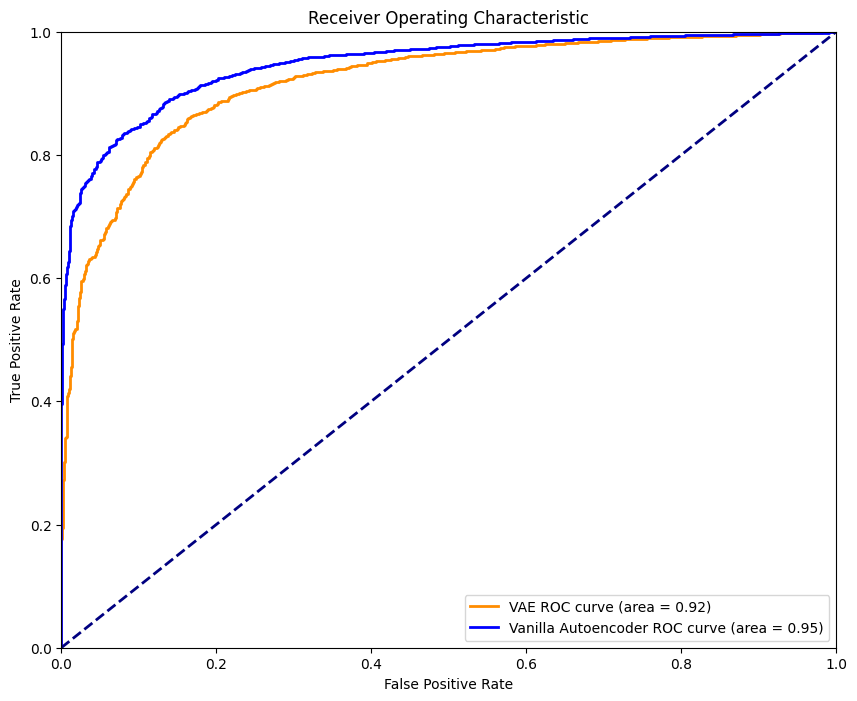

In [19]:
reconstructed = vae.predict(test_X, verbose=VERBOSE)
vae_mse = np.mean(np.square(test_X - reconstructed), axis=(1,2,3))
vae_metrics = calculate_metrics(test_y, vae_mse, THRESHOLD)
# Display metrics in a table format
print("\nβ-VAE Performance Metrics:")
print(tabulate(vae_metrics, headers="firstrow", tablefmt="grid"))

# Calculate ROC AUC score
fpr_vae, tpr_vae, thresholds  = roc_curve(test_y, vae_mse)

# Calculate Area Under Curve (AUC)
roc_auc_vae = auc(fpr_vae, tpr_vae)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_vae, tpr_vae, color='darkorange', lw=2, label=f'VAE ROC curve (area = {roc_auc_vae:.2f})')
plt.plot(fpr_vanilla, tpr_vanilla, color='blue', lw=2, label=f'Vanilla Autoencoder ROC curve (area = {roc_auc_vanilla:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
